# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 1 in Shi Jin's paper (2008-jy-phase.pdf):
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = e^{-25x^2}, \ S_0(x) = -0.2\log(2\cosh(5x)).
$$

Periodic BC.

Domain: $[-0.25, 0.25]\times [0, 0.5]$.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25x^2}\cos(-0.2\log(2\cosh(5x))/\varepsilon), \ q(x, 0) = e^{-25x^2}\sin(-0.2\log(2\cosh(5x))/\varepsilon),
$$
and bc
$$
p(x_0, t) = p(x_1, t), q(x_0, t) = q(x_1, t), p_x(x_0, t) = p_x(x_1, t), q_x(x_0, t) = q_x(x_1, t).
$$

In [1]:
NAME = "1"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple

In [3]:
key = random.PRNGKey(1001)
key, subkey = random.split(key, 2)

layers = [2] + [32]*2 + [2] # (x, t) -> (u, v)
c0 = 6.0
w0 = jnp.array([[10.0, 10.0]]).T # (w_x, w_t)
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
# direct_params = init_siren_params(subkey, layers, c0, w0, w1)
direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[-0.25, 0.], [0.25, 0.5]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1.0
V = 10.0

@jax.jit
def model(params, xt):
	xt_ = xt
	# first, normalize to [-1, 1] <- enforce periodic bc
# 	xt = jnp.sin(2.0*jnp.pi*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - jnp.pi)
# 	xt1 = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
# 	xt2 = index_update(xt1, index[0], jnp.sin(2*jnp.pi*xt1[0]/spatial_width))
# 	xt_ = index_update(xt2, index[1], jnp.cos(2*jnp.pi*xt2[1]/spatial_width))
	for w, b in params[:-1]:
		xt_ = jnp.sin(jnp.dot(xt_, w) + b)
	return jnp.dot(xt_, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, neumann = batch["collocation"], batch["dirichlet"], batch["neumann"]
	direct_params = params
	
	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
	# jacobian[i] = [[du/dx, du/dt],
	#                [dv/dx, dv/dt]]
	# i: the i^th input
	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
	# hessian[i] = [
    #				[[du/dxx, du/dxy],
	#                [du/dxy, du/dyy]],
	#               [[dv/dxx, dv/dxy],
	#                [dv/dxy, dv/dyy]]
	#              ]
	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
	duv_dxt_n = jacobian(direct_params, jnp.hstack([neumann.x, neumann.t]))
	du_dt_n, dv_dt_n = duv_dxt_n[:, 0:1, 1], duv_dxt_n[:, 1:2, 1]
	du_dx_n, dv_dx_n = duv_dxt_n[:, 0:1, 0], duv_dxt_n[:, 1:2, 0]
	
	duv_dxxtt_n = hessian(direct_params, jnp.hstack([neumann.x, neumann.t]))
	du_dxx_n, dv_dxx_n = duv_dxxtt_n[:, 0:1, 0, 0], duv_dxxtt_n[:, 1:2, 0, 0]
	
	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	loss_n_t1 = metaloss(du_dt_n, neumann.du_dt)
	loss_n_t2 = metaloss(dv_dt_n, neumann.dv_dt)
	loss_n_x1 = metaloss(du_dx_n, neumann.du_dx)
	loss_n_x2 = metaloss(dv_dx_n, neumann.dv_dx)
	loss_n_xx1 = metaloss(du_dxx_n, neumann.du_dxx)
	loss_n_xx2 = metaloss(dv_dxx_n, neumann.dv_dxx)
	loss_n = loss_n_t1 + loss_n_t2 + loss_n_x1 + loss_n_x2 + loss_n_xx1 + loss_n_xx2
	
	return loss_c, loss_d, loss_n


@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_n = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["n"]*loss_n + l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_n = loss_fn_(params, batch)
	l1 = l1_regularization(params, w["l1"])
	l2 = l2_regularization(params, w["l2"])
	return w["c"]*loss_c + w["d"]*loss_d + w["n"]*loss_n, loss_c, loss_d, loss_n, l1, l2

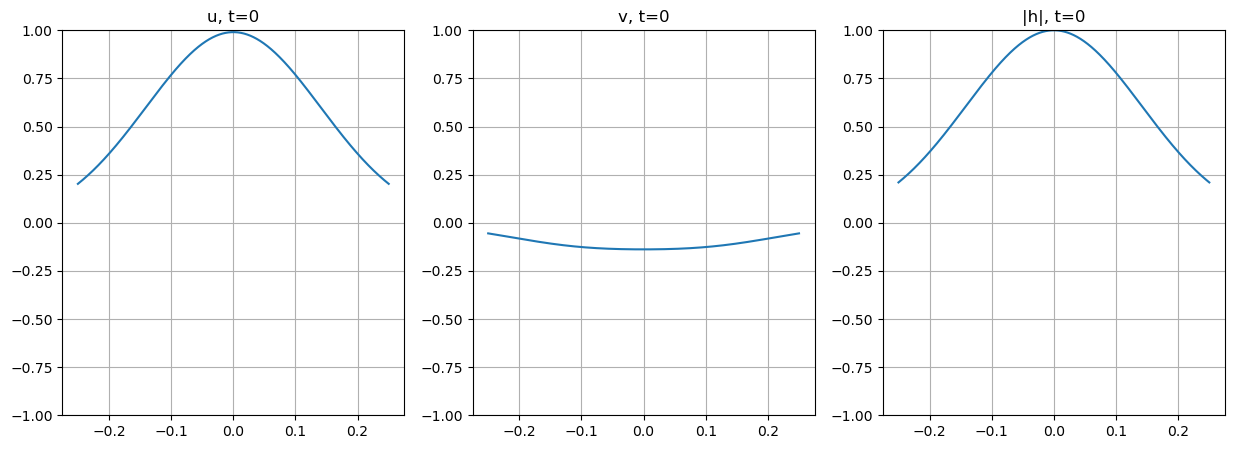

In [5]:
u0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))
v0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))

u0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))
v0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

du0_dxx_fn = lambda xt: jax.vmap(jax.hessian(u0_fn_), in_axes = 0)(xt)[:, 0, 0:1]
dv0_dxx_fn = lambda xt: jax.vmap(jax.hessian(v0_fn_), in_axes = 0)(xt)[:, 0, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 1000
x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)
du_dxx_i = du0_dxx_fn(jnp.hstack([x_i, t_i]))
dv_dxx_i = dv0_dxx_fn(jnp.hstack([x_i, t_i]))
du_dt_i = 1.0/epsilon*(V*v_i - epsilon**2/2*dv_dxx_i)
dv_dt_i = 1.0/epsilon*(epsilon**2/2*du_dxx_i - V*u_i)
du_dx_i = du0_dx_fn(jnp.hstack([x_i, t_i]))
dv_dx_i = dv0_dx_fn(jnp.hstack([x_i, t_i]))

n_cx = 1000
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_Neumann = namedtuple("dataset_Neumann", ["x", "t", "du_dt", "dv_dt", "du_dx", "dv_dx", "du_dxx", "dv_dxx"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x]),
								 jnp.vstack([dirichlet.t]))
neumann = dataset_Neumann(x_i, t_i, du_dt_i, dv_dt_i, du_dx_i, dv_dx_i, du_dxx_i, dv_dxx_i)

class Time_Marching_Generator:
	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every):
		self.key = key
		self.spatial_points = spatial_points
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = 0
		self._count2 = update_every
		self.update_every = update_every
		
	def _update(self, key, tmax):
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self.key, subkey = random.split(self.key)
			self._update(subkey, tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self.spatial_points, self._t

In [6]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 10000
print_every = 200
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1, "neumann": 1000}
weights = {"c": 0, "d": 1.0, "n": 0.0, "l1": 0.0, "l2": 0.0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Neumann = Batch_Generator(subkeys[1], neumann, batch_size["neumann"])
Collocation = Time_Marching_Generator(subkeys[3], x_c, domain[:, 1], n_cx, iterations, 1)

params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "n", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/14, 11:36:31, Iteration: 0, Train Loss: 7.2298e-01, c: 3.2134e-01, d: 7.2298e-01, n: 4.6511e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:36:34, Iteration: 200, Train Loss: 2.4914e-01, c: 7.6204e+00, d: 2.4914e-01, n: 4.6412e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:36:37, Iteration: 400, Train Loss: 2.4780e-01, c: 7.7073e+00, d: 2.4780e-01, n: 4.6336e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:36:41, Iteration: 600, Train Loss: 1.5693e-01, c: 1.3960e+01, d: 1.5693e-01, n: 4.3695e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:36:44, Iteration: 800, Train Loss: 2.9438e-02, c: 1.8156e+01, d: 2.9438e-02, n: 3.4444e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:36:47, Iteration: 1000, Train Loss: 1.2666e-02, c: 1.7601e+01, d: 1.2666e-02, n: 2.4019e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:36:51, Iteration: 1200, Train Loss: 4.2140e-03, c: 1.8843e+01, d: 4.2140e-03, n: 2.2557e+01, l1_reg: 0.0000e+0

In [8]:
start_iteration += iterations
iterations = 20000
print_every = 200
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1, "neumann": 1000}
weights = {"c": 0, "d": 1.0, "n": 1e-3, "l1": 0.0, "l2": 0.0}


for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "n", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/14, 11:41:15, Iteration: 10000, Train Loss: 2.3920e-02, c: 1.8888e+01, d: 2.3511e-03, n: 2.1569e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:41:19, Iteration: 10200, Train Loss: 2.2099e-02, c: 1.6376e+01, d: 2.3753e-03, n: 1.9724e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:41:22, Iteration: 10400, Train Loss: 2.1664e-02, c: 1.6121e+01, d: 2.2793e-03, n: 1.9385e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:41:26, Iteration: 10600, Train Loss: 2.3968e-02, c: 1.5909e+01, d: 4.8975e-03, n: 1.9070e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:41:29, Iteration: 10800, Train Loss: 2.6411e-02, c: 1.5711e+01, d: 7.5794e-03, n: 1.8832e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:41:32, Iteration: 11000, Train Loss: 2.2711e-02, c: 1.5520e+01, d: 4.1894e-03, n: 1.8521e+01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:41:36, Iteration: 11200, Train Loss: 2.0228e-02, c: 1.5284e+01, d: 2.0290e-03, n: 1.8199e+01, l1_

2020/08/14, 11:44:22, Iteration: 21200, Train Loss: 7.5630e-03, c: 4.3512e+00, d: 2.4144e-03, n: 5.1486e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:44:26, Iteration: 21400, Train Loss: 9.0994e-03, c: 4.3153e+00, d: 4.0442e-03, n: 5.0552e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:44:29, Iteration: 21600, Train Loss: 6.9652e-03, c: 4.1992e+00, d: 1.9643e-03, n: 5.0009e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:44:32, Iteration: 21800, Train Loss: 9.5905e-03, c: 4.2789e+00, d: 4.6416e-03, n: 4.9488e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:44:36, Iteration: 22000, Train Loss: 9.2210e-03, c: 4.1838e+00, d: 4.3333e-03, n: 4.8877e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:44:39, Iteration: 22200, Train Loss: 8.1886e-03, c: 4.1810e+00, d: 3.2407e-03, n: 4.9479e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:44:42, Iteration: 22400, Train Loss: 9.7305e-03, c: 4.1446e+00, d: 4.8227e-03, n: 4.9078e+00, l1_

In [10]:
start_iteration += iterations
iterations = 20000
print_every = 200
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1, "neumann": 1000}
weights = {"c": 0, "d": 1.0, "n": 1e-2, "l1": 0.0, "l2": 0.0}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "n", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/14, 11:48:05, Iteration: 30000, Train Loss: 4.7668e-02, c: 3.9831e+00, d: 2.1054e-03, n: 4.5562e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:48:09, Iteration: 30200, Train Loss: 4.6258e-02, c: 3.8777e+00, d: 1.6491e-03, n: 4.4609e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:48:12, Iteration: 30400, Train Loss: 4.6017e-02, c: 3.8356e+00, d: 2.4317e-03, n: 4.3586e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:48:16, Iteration: 30600, Train Loss: 4.7018e-02, c: 3.7705e+00, d: 3.9707e-03, n: 4.3048e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:48:19, Iteration: 30800, Train Loss: 4.6222e-02, c: 3.7459e+00, d: 3.5068e-03, n: 4.2715e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:48:22, Iteration: 31000, Train Loss: 4.5314e-02, c: 3.7087e+00, d: 3.1816e-03, n: 4.2133e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:48:26, Iteration: 31200, Train Loss: 4.3378e-02, c: 3.6634e+00, d: 1.8542e-03, n: 4.1524e+00, l1_

2020/08/14, 11:51:13, Iteration: 41200, Train Loss: 1.7736e-02, c: 1.1737e+00, d: 2.4954e-03, n: 1.5241e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:51:17, Iteration: 41400, Train Loss: 1.5056e-02, c: 1.0355e+00, d: 1.6399e-03, n: 1.3416e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:51:20, Iteration: 41600, Train Loss: 1.4342e-02, c: 8.9674e-01, d: 2.0479e-03, n: 1.2294e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:51:23, Iteration: 41800, Train Loss: 1.5790e-02, c: 7.2879e-01, d: 4.4740e-03, n: 1.1316e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:51:27, Iteration: 42000, Train Loss: 1.1718e-02, c: 6.3640e-01, d: 2.3046e-03, n: 9.4130e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:51:30, Iteration: 42200, Train Loss: 1.0459e-02, c: 5.4944e-01, d: 1.9835e-03, n: 8.4752e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:51:33, Iteration: 42400, Train Loss: 8.2186e-03, c: 4.6015e-01, d: 1.7580e-03, n: 6.4607e-01, l1_

In [12]:
start_iteration += iterations
iterations = 20000
print_every = 200
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1, "neumann": 1000}
weights = {"c": 0, "d": 1.0, "n": 1e-2, "l1": 0.0, "l2": 0.0}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "n", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/14, 11:55:43, Iteration: 50000, Train Loss: 8.4341e-03, c: 3.6401e-01, d: 1.4891e-03, n: 6.9450e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:55:47, Iteration: 50200, Train Loss: 7.0086e-03, c: 3.5069e-01, d: 2.1028e-03, n: 4.9057e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:55:50, Iteration: 50400, Train Loss: 7.8134e-03, c: 3.5601e-01, d: 2.3357e-03, n: 5.4777e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:55:53, Iteration: 50600, Train Loss: 6.7120e-03, c: 3.4777e-01, d: 1.5024e-03, n: 5.2096e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:55:57, Iteration: 50800, Train Loss: 7.0237e-03, c: 3.4889e-01, d: 1.5352e-03, n: 5.4885e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:56:00, Iteration: 51000, Train Loss: 8.4233e-03, c: 3.4968e-01, d: 3.5963e-03, n: 4.8270e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:56:03, Iteration: 51200, Train Loss: 8.3034e-03, c: 3.4524e-01, d: 2.3600e-03, n: 5.9435e-01, l1_

2020/08/14, 11:58:50, Iteration: 61200, Train Loss: 6.6116e-03, c: 3.1495e-01, d: 1.8093e-03, n: 4.8023e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:58:53, Iteration: 61400, Train Loss: 7.0339e-03, c: 3.3677e-01, d: 1.8057e-03, n: 5.2282e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:58:56, Iteration: 61600, Train Loss: 9.8814e-03, c: 3.4444e-01, d: 4.0784e-03, n: 5.8029e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:59:00, Iteration: 61800, Train Loss: 6.6890e-03, c: 3.2136e-01, d: 1.1774e-03, n: 5.5116e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:59:03, Iteration: 62000, Train Loss: 6.7309e-03, c: 3.1902e-01, d: 1.2963e-03, n: 5.4347e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:59:07, Iteration: 62200, Train Loss: 7.3389e-03, c: 3.2991e-01, d: 1.6162e-03, n: 5.7227e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 11:59:10, Iteration: 62400, Train Loss: 6.5780e-03, c: 3.1205e-01, d: 2.0860e-03, n: 4.4920e-01, l1_

In [13]:
start_iteration += iterations
iterations = 20000
print_every = 200
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1, "neumann": 1000}
weights = {"c": 0, "d": 1.0, "n": 1e-1, "l1": 0.0, "l2": 0.0}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "n", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/14, 12:03:49, Iteration: 70000, Train Loss: 2.0483e-01, c: 7.9798e-01, d: 8.2063e-03, n: 1.9663e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:03:52, Iteration: 70200, Train Loss: 6.1675e-02, c: 3.1531e-01, d: 2.6360e-03, n: 5.9039e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:03:56, Iteration: 70400, Train Loss: 4.5864e-02, c: 2.7392e-01, d: 1.3369e-03, n: 4.4527e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:03:59, Iteration: 70600, Train Loss: 5.2185e-02, c: 2.8449e-01, d: 1.5854e-03, n: 5.0599e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:04:02, Iteration: 70800, Train Loss: 4.6601e-02, c: 2.7453e-01, d: 1.4314e-03, n: 4.5170e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:04:05, Iteration: 71000, Train Loss: 4.3967e-02, c: 2.7694e-01, d: 2.0616e-03, n: 4.1906e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:04:09, Iteration: 71200, Train Loss: 5.8260e-02, c: 2.9020e-01, d: 1.6386e-03, n: 5.6621e-01, l1_

2020/08/14, 12:06:54, Iteration: 81200, Train Loss: 3.3694e-02, c: 1.7593e-01, d: 1.3844e-03, n: 3.2309e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:06:57, Iteration: 81400, Train Loss: 4.5639e-02, c: 2.2193e-01, d: 1.9440e-03, n: 4.3695e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:07:01, Iteration: 81600, Train Loss: 3.4240e-02, c: 1.9113e-01, d: 1.4277e-03, n: 3.2813e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:07:04, Iteration: 81800, Train Loss: 4.2105e-02, c: 2.0723e-01, d: 1.7340e-03, n: 4.0371e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:07:07, Iteration: 82000, Train Loss: 3.4283e-02, c: 1.9554e-01, d: 1.2422e-03, n: 3.3040e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:07:11, Iteration: 82200, Train Loss: 3.1154e-02, c: 1.7573e-01, d: 5.8375e-04, n: 3.0570e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:07:14, Iteration: 82400, Train Loss: 3.9332e-02, c: 2.2057e-01, d: 1.3693e-03, n: 3.7963e-01, l1_

In [15]:
start_iteration += iterations
iterations = 20000
print_every = 200
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1, "neumann": 1000}
weights = {"c": 0, "d": 1.0, "n": 1.0, "l1": 0.0, "l2": 0.0}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "n", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/14, 12:10:34, Iteration: 90000, Train Loss: 4.2086e+00, c: 1.8434e+00, d: 1.5016e-02, n: 4.1936e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:10:37, Iteration: 90200, Train Loss: 8.6540e-01, c: 3.7377e-01, d: 3.9874e-03, n: 8.6142e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:10:41, Iteration: 90400, Train Loss: 4.5085e-01, c: 1.9347e-01, d: 2.3403e-03, n: 4.4851e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:10:44, Iteration: 90600, Train Loss: 3.5027e-01, c: 2.4471e-01, d: 1.9542e-03, n: 3.4832e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:10:47, Iteration: 90800, Train Loss: 2.9909e-01, c: 1.5847e-01, d: 1.9367e-03, n: 2.9715e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:10:51, Iteration: 91000, Train Loss: 3.6150e-01, c: 1.5112e-01, d: 1.8942e-03, n: 3.5960e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:10:54, Iteration: 91200, Train Loss: 3.8967e-01, c: 1.8530e-01, d: 3.2290e-03, n: 3.8644e-01, l1_

2020/08/14, 12:13:40, Iteration: 101200, Train Loss: 2.4938e-01, c: 9.4549e-02, d: 2.6077e-03, n: 2.4677e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:13:43, Iteration: 101400, Train Loss: 2.9842e-01, c: 1.2799e-01, d: 1.5088e-03, n: 2.9691e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:13:46, Iteration: 101600, Train Loss: 2.3201e-01, c: 1.1667e-01, d: 1.8528e-03, n: 2.3015e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:13:50, Iteration: 101800, Train Loss: 2.1409e-01, c: 8.2547e-02, d: 1.5224e-03, n: 2.1257e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:13:53, Iteration: 102000, Train Loss: 2.7769e-01, c: 1.2125e-01, d: 9.6805e-04, n: 2.7672e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:13:56, Iteration: 102200, Train Loss: 2.5237e-01, c: 1.1854e-01, d: 2.6433e-03, n: 2.4973e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:14:00, Iteration: 102400, Train Loss: 2.5442e-01, c: 1.0274e-01, d: 2.9273e-03, n: 2.5149e-

In [17]:
start_iteration += iterations
iterations = 20000
print_every = 200
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1, "neumann": 1000}
weights = {"c": 0, "d": 10.0, "n": 10.0, "l1": 0.0, "l2": 0.0}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "n", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/14, 12:16:43, Iteration: 110000, Train Loss: 3.6612e+01, c: 1.6451e+00, d: 1.3092e-02, n: 3.6481e+00, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:16:46, Iteration: 110200, Train Loss: 5.9352e+00, c: 2.7485e-01, d: 3.6217e-03, n: 5.8989e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:16:50, Iteration: 110400, Train Loss: 4.4103e+00, c: 2.1229e-01, d: 2.9975e-03, n: 4.3804e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:16:53, Iteration: 110600, Train Loss: 4.2305e+00, c: 1.9016e-01, d: 2.5421e-03, n: 4.2051e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:16:56, Iteration: 110800, Train Loss: 2.6321e+00, c: 1.1863e-01, d: 3.7420e-03, n: 2.5947e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:17:00, Iteration: 111000, Train Loss: 2.3016e+00, c: 9.8142e-02, d: 1.2222e-03, n: 2.2894e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:17:03, Iteration: 111200, Train Loss: 3.0239e+00, c: 1.0297e-01, d: 2.0111e-03, n: 3.0038e-

2020/08/14, 12:19:46, Iteration: 121000, Train Loss: 3.0090e+00, c: 1.1302e-01, d: 1.6824e-03, n: 2.9922e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:19:49, Iteration: 121200, Train Loss: 2.4471e+00, c: 1.0472e-01, d: 2.5755e-03, n: 2.4213e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:19:52, Iteration: 121400, Train Loss: 2.5247e+00, c: 9.7277e-02, d: 1.8205e-03, n: 2.5065e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:19:56, Iteration: 121600, Train Loss: 2.6663e+00, c: 1.0978e-01, d: 1.7965e-03, n: 2.6484e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:19:59, Iteration: 121800, Train Loss: 2.5131e+00, c: 1.0534e-01, d: 1.1700e-03, n: 2.5014e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:20:02, Iteration: 122000, Train Loss: 1.7717e+00, c: 9.4724e-02, d: 3.5463e-03, n: 1.7362e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:20:06, Iteration: 122200, Train Loss: 2.7143e+00, c: 1.2498e-01, d: 1.9458e-03, n: 2.6949e-

In [18]:
start_iteration += iterations
iterations = 100000
print_every = 200
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1000, "neumann": 1000}
weights = {"c": 0.1, "d": 1.0, "n": 1.0, "l1": 0.0, "l2": 0.0}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
# 		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "n", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/14, 12:23:16, Iteration: 130000, Train Loss: 1.2876e+00, c: 9.7911e+00, d: 2.4118e-03, n: 3.0609e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:23:20, Iteration: 130200, Train Loss: 9.2706e-01, c: 8.4577e+00, d: 1.2418e-04, n: 8.1164e-02, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:23:23, Iteration: 130400, Train Loss: 7.7727e-01, c: 6.9640e+00, d: 6.7458e-04, n: 8.0204e-02, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:23:27, Iteration: 130600, Train Loss: 7.3442e-01, c: 6.5295e+00, d: 3.9035e-04, n: 8.1077e-02, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:23:30, Iteration: 130800, Train Loss: 7.1143e-01, c: 5.9508e+00, d: 3.8667e-04, n: 1.1597e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:23:34, Iteration: 131000, Train Loss: 6.7931e-01, c: 6.0028e+00, d: 5.4036e-04, n: 7.8490e-02, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:23:37, Iteration: 131200, Train Loss: 6.1175e-01, c: 5.3371e+00, d: 1.7083e-04, n: 7.7862e-

2020/08/14, 12:26:28, Iteration: 141000, Train Loss: 6.1556e-01, c: 3.2075e+00, d: 2.3384e-03, n: 2.9248e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:26:32, Iteration: 141200, Train Loss: 4.9116e-01, c: 2.6732e+00, d: 1.5912e-03, n: 2.2225e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:26:36, Iteration: 141400, Train Loss: 6.5154e-01, c: 3.5838e+00, d: 2.2772e-03, n: 2.9089e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:26:39, Iteration: 141600, Train Loss: 5.3134e-01, c: 2.9738e+00, d: 1.8789e-03, n: 2.3208e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:26:42, Iteration: 141800, Train Loss: 5.9092e-01, c: 2.9947e+00, d: 1.3751e-03, n: 2.9007e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:26:46, Iteration: 142000, Train Loss: 6.8277e-01, c: 3.1909e+00, d: 3.8037e-03, n: 3.5987e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:26:50, Iteration: 142200, Train Loss: 5.5243e-01, c: 3.2116e+00, d: 2.9699e-03, n: 2.2831e-

2020/08/14, 12:29:40, Iteration: 152000, Train Loss: 4.9567e-01, c: 2.1646e+00, d: 2.0370e-03, n: 2.7718e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:29:43, Iteration: 152200, Train Loss: 4.7551e-01, c: 2.1967e+00, d: 1.4297e-03, n: 2.5441e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:29:47, Iteration: 152400, Train Loss: 5.3635e-01, c: 2.4578e+00, d: 3.0477e-03, n: 2.8753e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:29:50, Iteration: 152600, Train Loss: 4.1720e-01, c: 2.5272e+00, d: 1.7784e-03, n: 1.6270e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:29:54, Iteration: 152800, Train Loss: 4.7404e-01, c: 2.3221e+00, d: 7.0109e-04, n: 2.4113e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:29:57, Iteration: 153000, Train Loss: 4.4567e-01, c: 2.0295e+00, d: 1.3036e-03, n: 2.4142e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:30:01, Iteration: 153200, Train Loss: 4.5269e-01, c: 2.1995e+00, d: 2.6470e-03, n: 2.3009e-

2020/08/14, 12:32:50, Iteration: 163000, Train Loss: 4.3271e-01, c: 2.1367e+00, d: 1.8328e-03, n: 2.1721e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:32:54, Iteration: 163200, Train Loss: 5.3630e-01, c: 1.7024e+00, d: 4.0416e-03, n: 3.6201e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:32:58, Iteration: 163400, Train Loss: 4.4549e-01, c: 1.9489e+00, d: 3.1700e-03, n: 2.4742e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:33:01, Iteration: 163600, Train Loss: 3.6369e-01, c: 1.9026e+00, d: 2.6961e-03, n: 1.7074e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:33:04, Iteration: 163800, Train Loss: 3.8287e-01, c: 1.9104e+00, d: 1.6149e-03, n: 1.9021e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:33:08, Iteration: 164000, Train Loss: 3.7089e-01, c: 2.0943e+00, d: 1.6990e-03, n: 1.5975e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:33:11, Iteration: 164200, Train Loss: 4.7071e-01, c: 1.8338e+00, d: 1.6666e-03, n: 2.8566e-

2020/08/14, 12:36:00, Iteration: 174000, Train Loss: 3.7608e-01, c: 1.5426e+00, d: 1.1490e-03, n: 2.2067e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:36:04, Iteration: 174200, Train Loss: 3.4008e-01, c: 1.5138e+00, d: 1.3002e-03, n: 1.8739e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:36:07, Iteration: 174400, Train Loss: 4.2201e-01, c: 1.4492e+00, d: 1.1598e-03, n: 2.7593e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:36:11, Iteration: 174600, Train Loss: 4.4071e-01, c: 1.6202e+00, d: 1.6483e-03, n: 2.7704e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:36:14, Iteration: 174800, Train Loss: 4.6259e-01, c: 1.6320e+00, d: 1.4949e-03, n: 2.9789e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:36:18, Iteration: 175000, Train Loss: 3.7855e-01, c: 1.6377e+00, d: 1.4595e-03, n: 2.1332e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:36:21, Iteration: 175200, Train Loss: 4.3310e-01, c: 1.6765e+00, d: 1.4470e-03, n: 2.6399e-

2020/08/14, 12:39:10, Iteration: 185000, Train Loss: 3.3937e-01, c: 1.2997e+00, d: 1.0869e-03, n: 2.0830e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:39:13, Iteration: 185200, Train Loss: 3.3947e-01, c: 1.3138e+00, d: 8.1563e-04, n: 2.0728e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:39:17, Iteration: 185400, Train Loss: 2.4590e-01, c: 1.2276e+00, d: 7.5662e-04, n: 1.2238e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:39:20, Iteration: 185600, Train Loss: 3.9782e-01, c: 1.6436e+00, d: 1.2382e-03, n: 2.3222e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:39:23, Iteration: 185800, Train Loss: 2.9573e-01, c: 1.2362e+00, d: 1.2276e-03, n: 1.7088e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:39:27, Iteration: 186000, Train Loss: 3.4063e-01, c: 1.5317e+00, d: 1.2932e-03, n: 1.8617e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:39:30, Iteration: 186200, Train Loss: 3.2249e-01, c: 1.4369e+00, d: 6.1734e-04, n: 1.7818e-

2020/08/14, 12:42:20, Iteration: 196000, Train Loss: 3.6593e-01, c: 1.5234e+00, d: 1.3061e-03, n: 2.1228e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:42:23, Iteration: 196200, Train Loss: 3.1630e-01, c: 1.5033e+00, d: 2.5340e-03, n: 1.6344e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:42:27, Iteration: 196400, Train Loss: 3.6414e-01, c: 1.3293e+00, d: 2.0072e-03, n: 2.2919e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:42:30, Iteration: 196600, Train Loss: 4.2261e-01, c: 1.6435e+00, d: 2.2393e-03, n: 2.5602e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:42:33, Iteration: 196800, Train Loss: 3.8821e-01, c: 1.4787e+00, d: 1.4694e-03, n: 2.3888e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:42:37, Iteration: 197000, Train Loss: 3.8674e-01, c: 1.4274e+00, d: 1.2375e-03, n: 2.4277e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:42:40, Iteration: 197200, Train Loss: 3.4413e-01, c: 1.2028e+00, d: 2.9165e-03, n: 2.2093e-

2020/08/14, 12:45:29, Iteration: 207000, Train Loss: 3.1883e-01, c: 1.1906e+00, d: 2.0442e-03, n: 1.9773e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:45:33, Iteration: 207200, Train Loss: 3.1682e-01, c: 1.2117e+00, d: 1.2155e-03, n: 1.9443e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:45:36, Iteration: 207400, Train Loss: 2.6944e-01, c: 1.3660e+00, d: 1.3475e-03, n: 1.3150e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:45:40, Iteration: 207600, Train Loss: 3.3795e-01, c: 1.3759e+00, d: 1.2502e-03, n: 1.9911e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:45:43, Iteration: 207800, Train Loss: 3.0960e-01, c: 1.2116e+00, d: 1.1713e-03, n: 1.8727e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:45:47, Iteration: 208000, Train Loss: 3.5306e-01, c: 1.4394e+00, d: 4.4755e-03, n: 2.0465e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:45:50, Iteration: 208200, Train Loss: 3.0506e-01, c: 1.3516e+00, d: 1.4676e-03, n: 1.6844e-

2020/08/14, 12:48:39, Iteration: 218000, Train Loss: 2.9504e-01, c: 1.2524e+00, d: 2.0150e-03, n: 1.6779e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:48:43, Iteration: 218200, Train Loss: 3.2037e-01, c: 1.3270e+00, d: 1.8128e-03, n: 1.8586e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:48:46, Iteration: 218400, Train Loss: 2.3456e-01, c: 9.9393e-01, d: 1.9774e-03, n: 1.3319e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:48:49, Iteration: 218600, Train Loss: 3.0325e-01, c: 1.1275e+00, d: 2.0202e-03, n: 1.8848e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:48:53, Iteration: 218800, Train Loss: 3.1117e-01, c: 1.0569e+00, d: 1.3965e-03, n: 2.0409e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:48:56, Iteration: 219000, Train Loss: 2.7356e-01, c: 9.6325e-01, d: 1.3493e-03, n: 1.7589e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:49:00, Iteration: 219200, Train Loss: 3.1698e-01, c: 1.1907e+00, d: 3.2279e-03, n: 1.9468e-

2020/08/14, 12:51:49, Iteration: 229000, Train Loss: 2.8791e-01, c: 1.0737e+00, d: 1.9749e-03, n: 1.7856e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:51:53, Iteration: 229200, Train Loss: 2.7235e-01, c: 1.0954e+00, d: 1.8176e-03, n: 1.6099e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:51:56, Iteration: 229400, Train Loss: 4.1175e-01, c: 1.1778e+00, d: 1.3256e-03, n: 2.9264e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:52:00, Iteration: 229600, Train Loss: 2.9298e-01, c: 1.0589e+00, d: 1.0619e-03, n: 1.8603e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:52:03, Iteration: 229800, Train Loss: 2.9812e-01, c: 1.1478e+00, d: 2.1679e-03, n: 1.8116e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00
2020/08/14, 12:52:06, Iteration: 230000, Train Loss: 3.4169e-01, c: 9.9915e-01, d: 2.0869e-03, n: 2.3969e-01, l1_reg: 0.0000e+00, l2_reg: 0.0000e+00


In [19]:
from scipy.io import loadmat

uv_true = loadmat("ex1_epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([-0.25, 0.25])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 51)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 1000, blit = True)
plt.show()

<IPython.core.display.Javascript object>

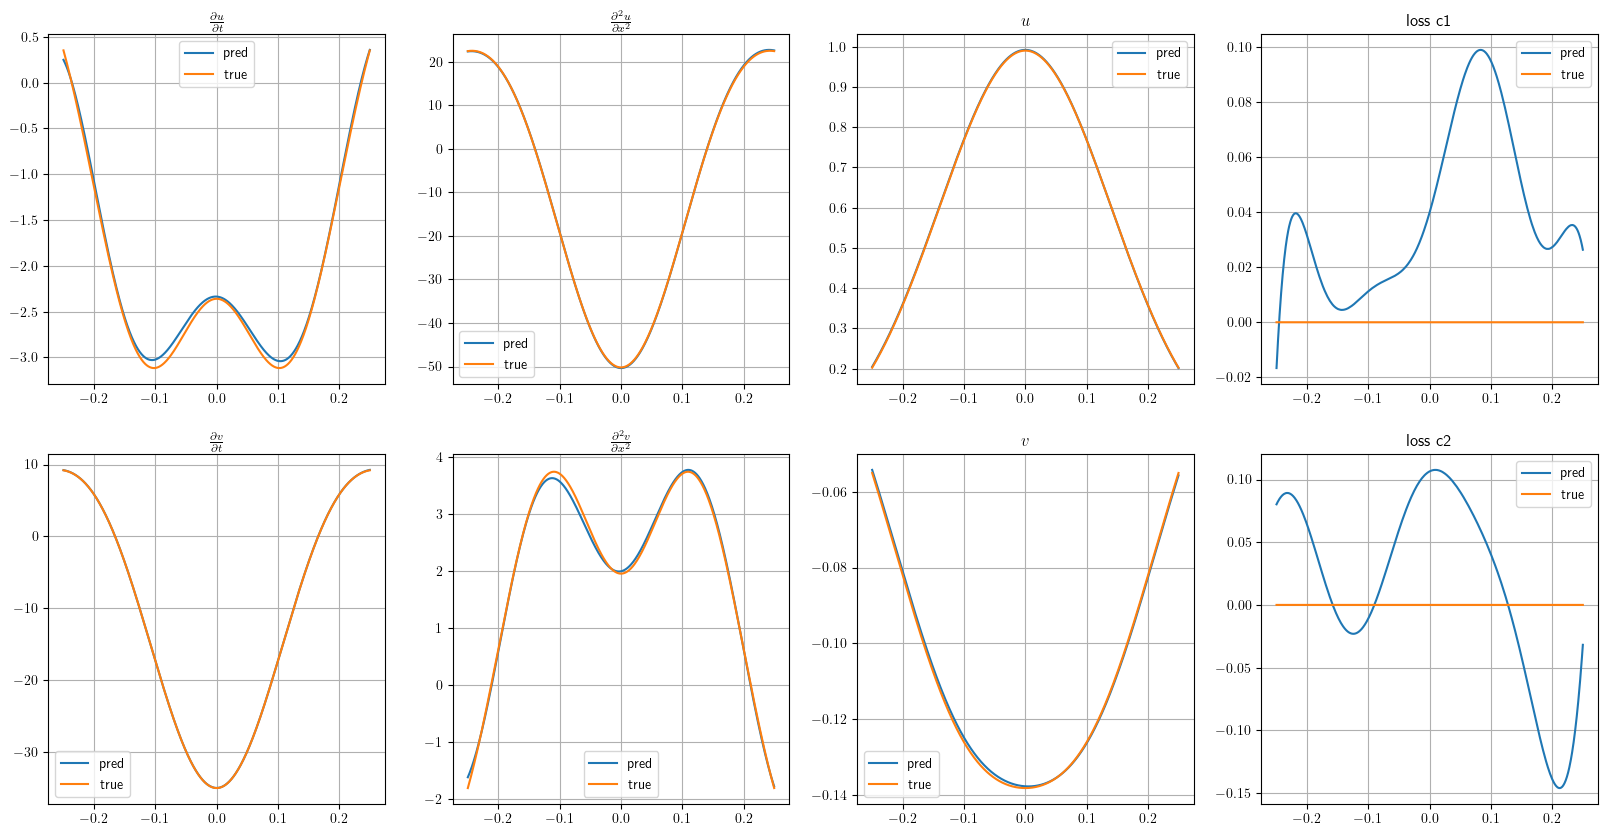

In [20]:
x = jnp.linspace(*domain[:, 0], 1000).reshape((-1, 1))
t = jnp.zeros_like(x)
xt = jnp.hstack([x, t])


# direct_params_ = direct_params
direct_params_ = get_params(opt_state)
duv_dxt = jacobian(direct_params_, xt)
du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
duv_dxxtt = hessian(direct_params_, xt)
du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
uv = model(direct_params_, xt)
u, v = uv[:, 0:1], uv[:, 1:2]
loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dt, dv0_dt = du0_dt_fn(xt), dv0_dt_fn(xt)
du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["text.usetex"] = True

f, ax = plt.subplots(2, 4, figsize = (20, 10))
ax[0][0].plot(x, du_dt, label = "pred")
ax[0][0].plot(x, du0_dt, label = "true")
ax[0][0].set_title(r"$\frac{\partial u}{\partial t}$")
ax[1][0].plot(x, dv_dt, label = "pred")
ax[1][0].plot(x, dv0_dt, label = "true")
ax[1][0].set_title(r"$\frac{\partial v}{\partial t}$")
ax[0][1].plot(x, du_dxx, label = "pred")
ax[0][1].plot(x, du0_dxx, label = "true")
ax[0][1].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
ax[1][1].plot(x, dv_dxx, label = "pred")
ax[1][1].plot(x, dv0_dxx, label = "true")
ax[1][1].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
ax[0][2].plot(x, u, label = "pred")
ax[0][2].plot(x, u0, label = "true")
ax[0][2].set_title(r"$u$")
ax[1][2].plot(x, v, label = "pred")
ax[1][2].plot(x, v0, label = "true")
ax[1][2].set_title(r"$v$")
ax[0][3].plot(x, loss_c1, label = "pred")
ax[0][3].plot(x, loss_c10, label = "true")
ax[0][3].set_title(r"loss c1")
ax[1][3].plot(x, loss_c2, label = "pred")
ax[1][3].plot(x, loss_c20, label = "true")
ax[1][3].set_title(r"loss c2")

for i in range(2):
	for j in range(4):
		ax[i][j].legend()
		ax[i][j].grid()
plt.show()